# Transfer learning on OxfordIIITpet dataset

importing libraries

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet
from torchvision import models
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
img_size = 224
imagenet_stats = ([0.485, 0.458, 0.406], [0.229,0.224,0.225])

transforms = T.Compose([
    T.Resize(img_size),
    T.Pad(8,padding_mode='reflect'),
    T.RandomCrop(img_size),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
])

Downloading training and testing datasets

In [3]:
train_dataset = OxfordIIITPet(root='data/OxfordIIITPet/train/',split="trainval", transform=transforms, download=True)
test_dataset = OxfordIIITPet(root='data/OxfordIIITPet/test/',split="test", transform=transforms, download=True)

In [4]:
len(train_dataset),len(test_dataset)

(3680, 3669)

Listing out all the classes present in the dataset

In [5]:
print(train_dataset.classes)

['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


defining a helper function to display images

In [6]:
def showimage(img, label):
    print(f'Label : {train_dataset.classes[label]} , {label}')
    # Denormalizing the image
    img = img * imagenet_stats[1][0] + imagenet_stats[0][0]
    plt.imshow(img.permute(1,2,0))

Label : Abyssinian , 0


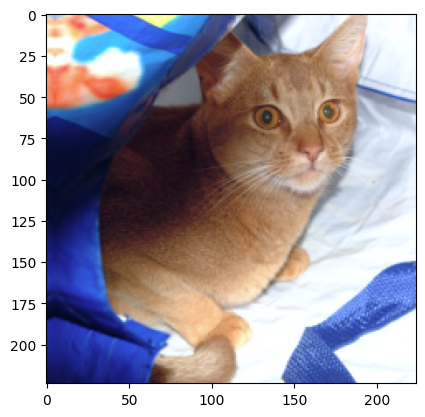

In [7]:
showimage(*train_dataset[0])

Label : American Pit Bull Terrier , 2


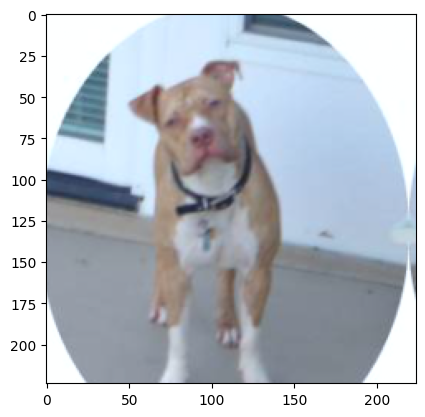

In [8]:
showimage(*train_dataset[125])

### Creating training and validation dataset

In [9]:
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_ds, valid_ds = random_split(train_dataset,[train_size,val_size])
len(train_ds),len(valid_ds)

(2944, 736)

In [10]:
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
def show_batch(dl):
    for images, _ in dl:
        _, ax = plt.subplots(figsize = (16,16))
        ax.set_xticks([])
        ax.set_yticks([])
        images = images[:64] * imagenet_stats[1][0] + imagenet_stats[0][0]
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

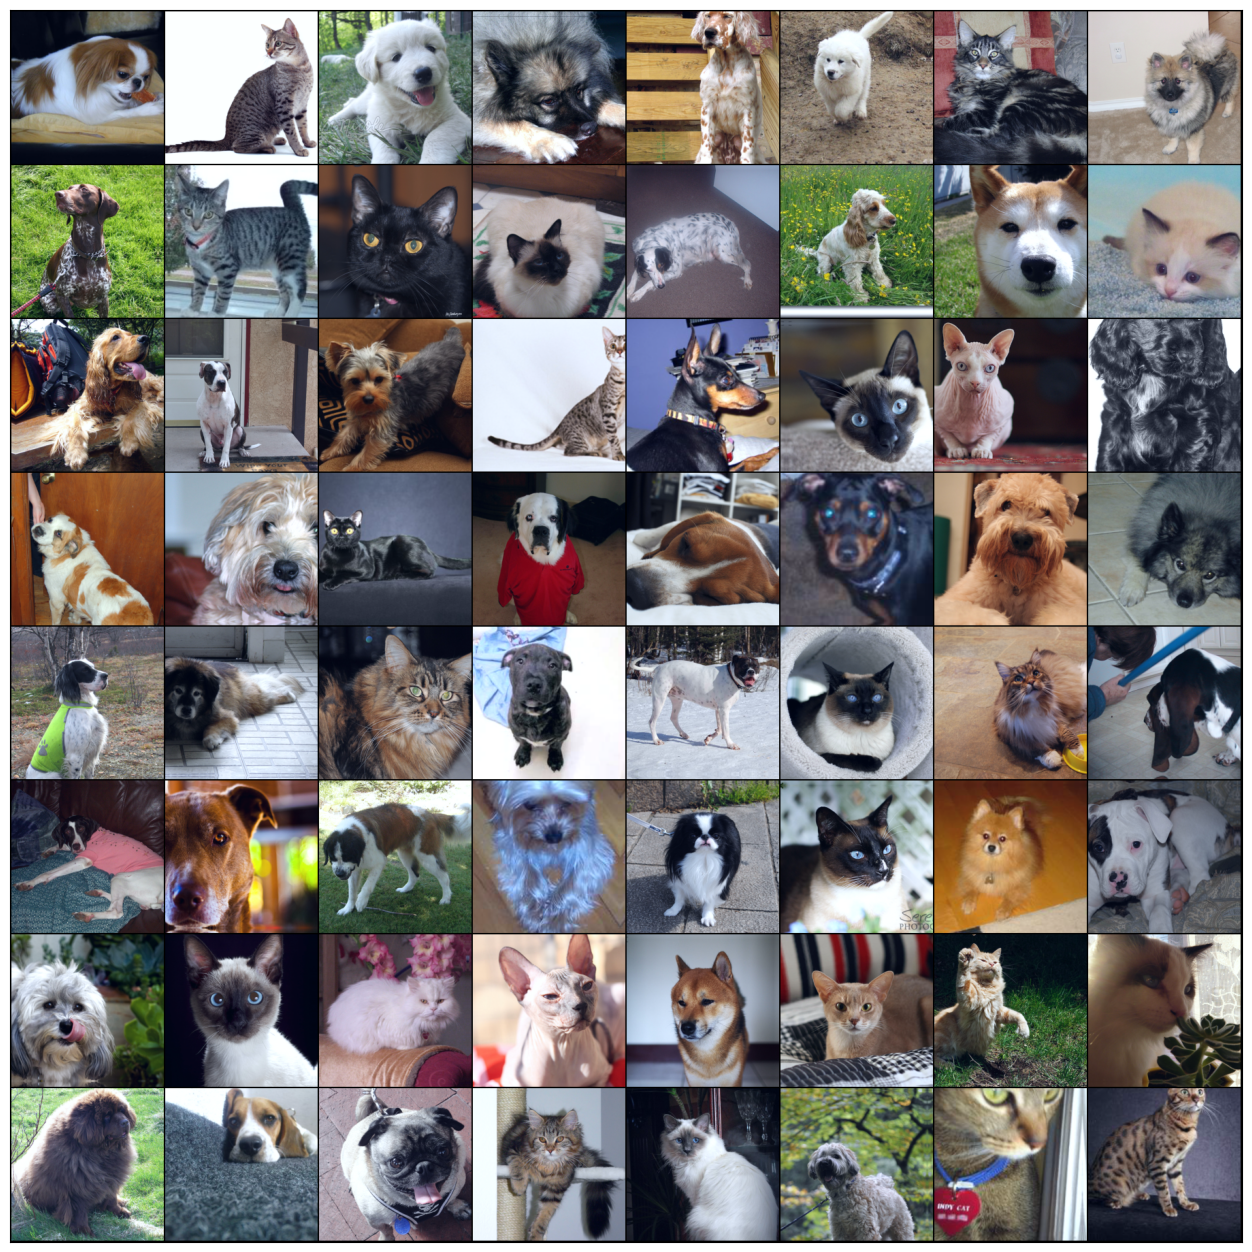

In [12]:
show_batch(train_dl)

### Modifying a pretrained model (ResNet34)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                     # Generate predictions
        loss = F.cross_entropy(out, labels)    # Calculate loss

        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                      # Generate predictions
        loss = F.cross_entropy(out, labels)     # Calculate loss
        acc = accuracy(out, labels)             # Calculate accuracy

        return {'val_loss' : loss.detach(), 'val_acc' : acc}  

    def validation_epoch_end(self, outputs):
        batch_losses = []
        batch_accs = []

        for x in outputs:
            batch_losses.append(x['val_loss']) 
            batch_accs.append(x['val_acc']) 

        epoch_loss = torch.stack(batch_losses).mean()   # combining losses
        epoch_acc = torch.stack(batch_accs).mean()      # combining accuracies

        return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], train_loss : {result['train_loss']}, val_loss : {result['val_loss']}, val_acc : {result['val_acc']}")

In [14]:
class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained= True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained = pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)


### GPU utilities and Training loop

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
def to_device(data, device):
    if isinstance(data, (tuple, list)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking= True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]

    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_fucn= torch.optim.SGD):
    history = []
    optimizer = opt_fucn(model.parameters(),lr)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay = 0 , grad_clip = None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record and update learning rates
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        print(f'result in tqdm {result}')
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [18]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Finetuning the Pretrained Model

In [19]:
model = PetsModel(len(train_dataset.classes))
to_device(model, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PetsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.791248321533203, 'val_acc': 0.029296875}]

In [21]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func )

  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 2.425884246826172, 'val_acc': 0.3914620578289032, 'train_loss': 1.4065723419189453, 'lrs': [0.0003999999999999993, 0.00040469811270412576, 0.0004187832540402635, 0.00044222785168280924, 0.00047498601173091674, 0.0005169936085479658, 0.0005681684102905107, 0.0006284102398809686, 0.000697601171108956, 0.0007756057594773842, 0.0008622713073414209, 0.0009574281628213065]}
Epoch [1], train_loss : 1.4065723419189453, val_loss : 2.425884246826172, val_acc : 0.3914620578289032


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 11.228404998779297, 'val_acc': 0.0396205335855484, 'train_loss': 0.4913976192474365, 'lrs': [0.001060890051903865, 0.0011724544430826468, 0.001291902943822842, 0.0014190017280749506, 0.0015535019940002316, 0.0016951404510119946, 0.0018436398351792914, 0.0019987094519840765, 0.002160045745369373, 0.0023273328919645236, 0.0025002434193242516, 0.0026784388469713654]}
Epoch [2], train_loss : 0.4913976192474365, val_loss : 11.228404998779297, val_acc : 0.0396205335855484


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 15.884542465209961, 'val_acc': 0.1057477667927742, 'train_loss': 0.9477693438529968, 'lrs': [0.002861570348988176, 0.0030492794368596225, 0.003241198661231369, 0.003436952331209167, 0.003636157249791435, 0.0038384234639953756, 0.004043355028208251, 0.004250550779269517, 0.004459605121766548, 0.004670108822006704, 0.004881649809111501, 0.005093813981664703]}
Epoch [3], train_loss : 0.9477693438529968, val_loss : 15.884542465209961, val_acc : 0.1057477667927742


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 18.219093322753906, 'val_acc': 0.0393415167927742, 'train_loss': 1.6796954870224, 'lrs': [0.005306186018335296, 0.005518350190888498, 0.005729891177993294, 0.005940394878233452, 0.006149449220730483, 0.006356644971791749, 0.006561576536004624, 0.006763842750208564, 0.006963047668790832, 0.007158801338768632, 0.007350720563140376, 0.007538429651011822]}
Epoch [4], train_loss : 1.6796954870224, val_loss : 18.219093322753906, val_acc : 0.0393415167927742


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 4.282347679138184, 'val_acc': 0.0824497789144516, 'train_loss': 1.5578402280807495, 'lrs': [0.007721561153028633, 0.007899756580675748, 0.008072667108035475, 0.008239954254630626, 0.008401290548015923, 0.008556360164820708, 0.008704859548988003, 0.008846498005999766, 0.008980998271925047, 0.009108097056177156, 0.009227545556917353, 0.009339109948096135]}
Epoch [5], train_loss : 1.5578402280807495, val_loss : 4.282347679138184, val_acc : 0.0824497789144516


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 4.531479835510254, 'val_acc': 0.1875, 'train_loss': 1.4353773593902588, 'lrs': [0.009442571837178693, 0.009537728692658579, 0.009624394240522615, 0.009702398828891044, 0.009771589760119031, 0.009831831589709487, 0.009883006391452032, 0.009925013988269083, 0.00995777214831719, 0.009981216745959736, 0.009995301887295874, 0.01]}
Epoch [6], train_loss : 1.4353773593902588, val_loss : 4.531479835510254, val_acc : 0.1875


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 2.3431930541992188, 'val_acc': 0.3950892686843872, 'train_loss': 1.0426037311553955, 'lrs': [0.009999125808060514, 0.009996503537927897, 0.009992134106552784, 0.009986019041829957, 0.00997816048206409, 0.009968561175222016, 0.009957224477971826, 0.009944154354509118, 0.009929355375170808, 0.009912832714836978, 0.009894592151121324, 0.009874640062350875]}
Epoch [7], train_loss : 1.0426037311553955, val_loss : 2.3431930541992188, val_acc : 0.3950892686843872


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 3.632718563079834, 'val_acc': 0.3409598171710968, 'train_loss': 0.9078627824783325, 'lrs': [0.009852983425335606, 0.009829629812928816, 0.00980458739137906, 0.009777864917474588, 0.009749471735481297, 0.009719417773875232, 0.009687713541870827, 0.009654370125746048, 0.009619399184965783, 0.009582812948104764, 0.009544624208571507, 0.009504846320134737]}
Epoch [8], train_loss : 0.9078627824783325, val_loss : 3.632718563079834, val_acc : 0.3409598171710968


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 3.254307270050049, 'val_acc': 0.3063616156578064, 'train_loss': 0.8003162145614624, 'lrs': [0.009463493192253872, 0.00942057928521518, 0.00937611960507533, 0.00933012969841412, 0.009282625646898149, 0.009233624061657435, 0.009183142077476858, 0.009131197346804489, 0.009077808033578922, 0.009022992806877747, 0.00896677083438937, 0.0089091617757105]}
Epoch [9], train_loss : 0.8003162145614624, val_loss : 3.254307270050049, val_acc : 0.3063616156578064


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 2.2855565547943115, 'val_acc': 0.41015625, 'train_loss': 0.6225842833518982, 'lrs': [0.00885018577547161, 0.008789863456292802, 0.00872821591157253, 0.008665264698111694, 0.008601031828575703, 0.008535539763797114, 0.008468811404921587, 0.008400870085399841, 0.00833173956282846, 0.00826144401064238, 0.008190008009661964, 0.008117456539497631]}
Epoch [10], train_loss : 0.6225842833518982, val_loss : 2.2855565547943115, val_acc : 0.41015625


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 3.230311155319214, 'val_acc': 0.3288225531578064, 'train_loss': 0.4678714871406555, 'lrs': [0.008043814969815023, 0.007969109051463795, 0.007893364907473107, 0.007816609023916949, 0.007738868240652573, 0.007660169741935153, 0.007580541046912057, 0.00750001, 0.007418604761148457, 0.007336353795992745, 0.007253285865900211, 0.007169430017913008]}
Epoch [11], train_loss : 0.4678714871406555, val_loss : 3.230311155319214, val_acc : 0.3288225531578064


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 1.5845847129821777, 'val_acc': 0.5895647406578064, 'train_loss': 0.3599488139152527, 'lrs': [0.007084815574590985, 0.006999472123758218, 0.006913429508156802, 0.006826717815011489, 0.006739367365508844, 0.006651408704194597, 0.006562872588292864, 0.006473789976951033, 0.006384192020414018, 0.006294110049131702, 0.006203575562803357, 0.0061126202193628925]}
Epoch [12], train_loss : 0.3599488139152527, val_loss : 1.5845847129821777, val_acc : 0.5895647406578064


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 1.3133633136749268, 'val_acc': 0.6411830186843872, 'train_loss': 0.24515287578105927, 'lrs': [0.006021275823908766, 0.005929574317582431, 0.005837547766399216, 0.005745228350035548, 0.005652648350576415, 0.005559840141227017, 0.005466836174992584, 0.0053736689733302504, 0.005280371114777014, 0.005186975223557743, 0.005093513958177183, 0.00500002]}
Epoch [13], train_loss : 0.24515287578105927, val_loss : 1.3133633136749268, val_acc : 0.6411830186843872


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 1.315098524093628, 'val_acc': 0.6477399468421936, 'train_loss': 0.17209021747112274, 'lrs': [0.004906526041822818, 0.004813064776442257, 0.004719668885222985, 0.00462637102666975, 0.004533203825007416, 0.004440199858772983, 0.004347391649423588, 0.004254811649964451, 0.004162492233600785, 0.00407046568241757, 0.0039787641760912346, 0.003887419780637108]}
Epoch [14], train_loss : 0.17209021747112274, val_loss : 1.315098524093628, val_acc : 0.6477399468421936


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 1.0537972450256348, 'val_acc': 0.736328125, 'train_loss': 0.11693056672811508, 'lrs': [0.0037964644371966446, 0.0037059299508682983, 0.0036158479795859824, 0.003526250023048967, 0.0034371674117071377, 0.0033486312958054057, 0.0032606726344911554, 0.0031733221849885125, 0.003086610491843199, 0.0030005678762417827, 0.0029152244254090167, 0.0028306099820869924]}
Epoch [15], train_loss : 0.11693056672811508, val_loss : 1.0537972450256348, val_acc : 0.736328125


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 0.8815356492996216, 'val_acc': 0.7586495876312256, 'train_loss': 0.07057353854179382, 'lrs': [0.002746754134099789, 0.0026636862040072557, 0.0025814352388515436, 0.0025000300000000016, 0.0024194989530879427, 0.002339870258064848, 0.0022611717593474284, 0.0021834309760830513, 0.002106675092526895, 0.0020309309485362042, 0.001956225030184977, 0.00188258346050237]}
Epoch [16], train_loss : 0.07057353854179382, val_loss : 0.8815356492996216, val_acc : 0.7586495876312256


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 0.7981513738632202, 'val_acc': 0.7726004123687744, 'train_loss': 0.042449116706848145, 'lrs': [0.0018100319903380363, 0.0017385959893576213, 0.0016683004371715396, 0.0015991699146001577, 0.0015312285950784123, 0.0014645002362028865, 0.0013990081714242988, 0.001334775301888306, 0.0012718240884274697, 0.0012101765437071972, 0.001149854224528391, 0.0010908782242895004]}
Epoch [17], train_loss : 0.042449116706848145, val_loss : 0.7981513738632202, val_acc : 0.7726004123687744


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 0.775752604007721, 'val_acc': 0.79296875, 'train_loss': 0.028193917125463486, 'lrs': [0.0010332691656106305, 0.0009770471931222536, 0.0009222319664210784, 0.000868842653195513, 0.0008168979225231413, 0.0007664159383425639, 0.0007174143531018529, 0.0006699103015858822, 0.0006239203949246697, 0.0005794607147848218, 0.0005365468077461283, 0.0004951936798652628]}
Epoch [18], train_loss : 0.028193917125463486, val_loss : 0.775752604007721, val_acc : 0.79296875


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 0.7692875862121582, 'val_acc': 0.7917131781578064, 'train_loss': 0.032411620020866394, 'lrs': [0.0004554157914284935, 0.0004172270518952364, 0.0003806408150342165, 0.0003456698742539522, 0.0003123264581291754, 0.0002806222261247683, 0.0002505682645187035, 0.0002221750825254118, 0.00019545260862094147, 0.00017041018707118479, 0.0001470565746643943, 0.00012539993764912555]}
Epoch [19], train_loss : 0.032411620020866394, val_loss : 0.7692875862121582, val_acc : 0.7917131781578064


  0%|          | 0/12 [00:00<?, ?it/s]

result in tqdm {'val_loss': 0.730941653251648, 'val_acc': 0.8071986436843872, 'train_loss': 0.02657136879861355, 'lrs': [0.00010544784887867613, 8.720728516302332e-05, 7.068462482919094e-05, 5.588564549088189e-05, 4.2815522028175566e-05, 3.147882477798485e-05, 2.1879517935909756e-05, 1.4020958170042977e-05, 7.905893447217334e-06, 3.536462072102727e-06, 9.141919394861322e-07, 4e-08]}
Epoch [20], train_loss : 0.02657136879861355, val_loss : 0.730941653251648, val_acc : 0.8071986436843872


We can plot the validation set accuracies and losses

In [23]:
def plot_accuracies(history):
    accuracy = [x['val_acc'] for x in history]
    plt.plot(accuracy, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

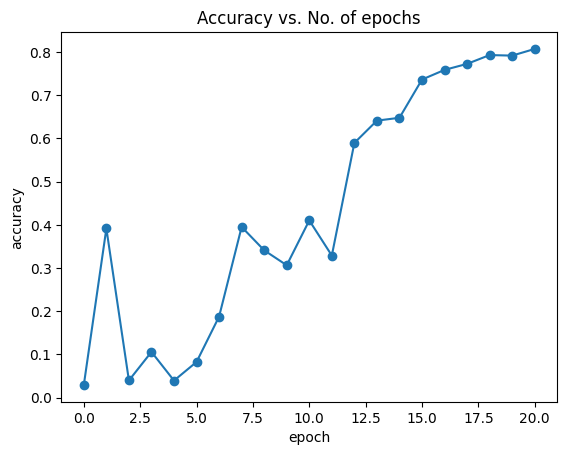

In [24]:
plot_accuracies(history)

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. Of epochs');

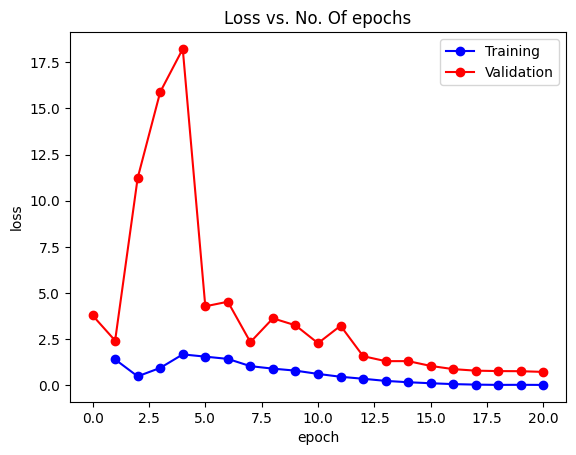

In [26]:
plot_losses(history)

## Testing with individual images


In [27]:
def predict_image(img, model):
    # convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get prediction from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim = 1)

    return train_dataset.classes[preds[0].item()]

Label : Abyssinian, Predicted : Abyssinian


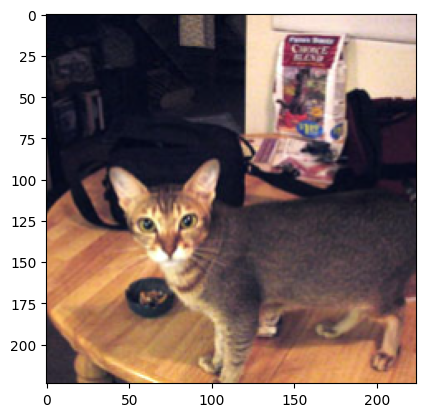

In [28]:
img,label = test_dataset[0]
print(f'Label : {train_dataset.classes[label]}, Predicted : {predict_image(img,model)}')
img = img * imagenet_stats[1][0] + imagenet_stats[0][0]
plt.imshow(img.permute(1,2,0));

Label : American Bulldog, Predicted : American Bulldog


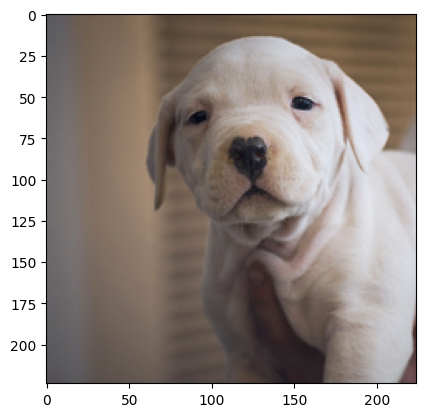

In [29]:
img,label = test_dataset[111]
print(f'Label : {train_dataset.classes[label]}, Predicted : {predict_image(img,model)}')
img = img * imagenet_stats[1][0] + imagenet_stats[0][0]
plt.imshow(img.permute(1,2,0));

Label : Great Pyrenees, Predicted : Great Pyrenees


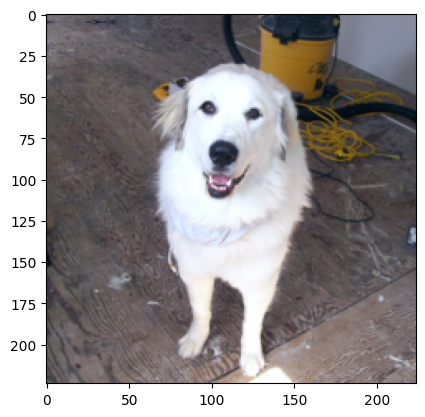

In [30]:
img,label = test_dataset[1497]
print(f'Label : {train_dataset.classes[label]}, Predicted : {predict_image(img,model)}')
img = img * imagenet_stats[1][0] + imagenet_stats[0][0]
plt.imshow(img.permute(1,2,0));

In [31]:
test_loader = DeviceDataLoader(DataLoader(train_dataset,batch_size*2), device)
result = evaluate(model,test_loader)
result

{'val_loss': 0.18572406470775604, 'val_acc': 0.9561360478401184}